# Notes

In [1]:
# Code: https://github.com/sgdecker/mjo
# Edited by Dave M : https://github.com/wxprediction/ForecastContest
# RMM/MJO Data: 'http://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt'

###############################
# Ideas for Improvement #######
###############################
### Evaluate in conjunction to teleconnections (NAO, AK Ridge, etc..)
### Evaluate conditioned on ENSO Phase
### Evaluate conditiononed on Teleconnection Phase (i.e., Phase 5 + neg NAO)
### Evaluate conditional by climate period
### Evaluate in conjunction to model guidance (need to think this out more)
### Evaluate each point as a function of lag
### Evaluate Directional Signal (cold vs warm)
########## Model Bias/Error as a function of phase/amp
########## Model Bias/Error as a function of the delta between MJO temp/pattern regime and the model guidance temp/pattern regime

# Load Packages

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request
from datetime import datetime, date, timedelta
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Define Parameters

In [3]:
###############################################
# -2 is contemperaneous, -17 = Days 16 to 20
###############################################
shift_num_days = -17

###############################################
# Selects analogs plus or minus 
# x days (analog range) of today's date and 
# from years indicated
###############################################
MarkDate='2018-01-15'  # Year is not relevant - only month and day
first_year = 1981
last_year = 2018
analog_range=30 # days

###############################################
# Evalutes the RMM in the following range
###############################################
RMM_Min   =-2.50
RMM_Steps =.25
RMM_Max   =abs(RMM_Min) + RMM_Steps

###############################################
# 'hdd_anom' or 'cdd_anom'
###############################################
DD_Type= 'hdd_anom'

# Load Functions

In [4]:
def get_data(shift_num_days):
    mjo_df = pd.read_pickle('mjo.pickle.xz')
    deg_day_df = pd.read_pickle('deg_days5.pickle.xz')
    df = mjo_df.join(deg_day_df, how='outer')

    mjo_mask = df.columns.isin(['RMM1', 'RMM2'])
    dd_mask = df.columns.isin(['cdd_anom', 'hdd_anom','cdd_30yrNorm', 'hdd_30yrNorm'])

    # MJO is available two days prior
    cols_to_shift = df.columns[mjo_mask]
    df[cols_to_shift] = df[cols_to_shift].shift(2)

    # Forecast is for 16-20 day period, so 17 days after today is center.
    cols_to_shift = df.columns[dd_mask]
 #   df[cols_to_shift] = df[cols_to_shift].shift(-17)
    df[cols_to_shift] = df[cols_to_shift].shift(shift_num_days)

    return df

In [5]:
def criteria_filter(c, r):
    res = np.sqrt((c['RMM1'] - r[0])**2 + (c['RMM2'] - r[1])**2) < .5

    return res

In [6]:
def find_analogs(df, today, rmm, first_year, last_year, analog_range):
    # Look for analogs plus or minus 45 days of today's date and between the years indicated
    tdelt = pd.to_timedelta(analog_range, 'D')

    periods = []
    for y in range(first_year, last_year+1):
        try:
            mid = pd.Timestamp(year=y, month=today.month, day=today.day)
        except ValueError:  # Leap day!
            mid = pd.Timestamp(year=y, month=3, day=1)
        prd = pd.period_range(mid - tdelt, mid + tdelt)
        for p in prd:
            periods.append(p.to_timestamp())
    periods = pd.to_datetime(periods)
    candidates = df.loc[periods]

    criteria = criteria_filter(candidates, rmm)
    analogs = candidates[criteria]

    return(analogs)

In [7]:
def draw_mjo_phase(ax):
    c = plt.Circle((0,0), radius=1, fill=False)
    ax.add_patch(c)

    s2 = np.sqrt(2)/2
    lines = ((( 1, 3), (0,0)), (( s2, 3), ( s2, 3)), ((0,0), ( 1, 3)), ((-s2,-3), ( s2, 3)),
             ((-1,-3), (0,0)), ((-s2,-3), (-s2,-3)), ((0,0), (-1,-3)), (( s2, 3), (-s2,-3)))
    params = {'c': 'k', 'ls': '--', 'lw': 1.}
    for xy in lines:
        ax.plot(xy[0], xy[1], **params)
 
    phases = ((-2.9, -1.2, '1'), (-1.2, -2.9, '2'), (1.1, -2.9, '3'), (2.7, -1.2, '4'),
              (-2.9,  1.2, '8'), (-1.2,  2.7, '7'), (1.1,  2.7, '6'), (2.7,  1.2, '5'))
    for p in phases:
        ax.text(*p)

# Research

In [8]:
DD_Mean_List=[]

today = pd.Timestamp(MarkDate)

df = get_data(shift_num_days)
rmm1_range=np.arange(RMM_Min,RMM_Max,RMM_Steps)
rmm2_range=np.arange(RMM_Min,RMM_Max,RMM_Steps)
analogs=np.zeros((500,len(rmm1_range), len(rmm2_range)))

for cur_rmm1 in rmm1_range:
    print ('RMM1 = ', "{:0.2f}".format(cur_rmm1))
    for cur_rmm2 in rmm2_range:
        analogs=find_analogs(df, today, (cur_rmm1, cur_rmm2), first_year, last_year, analog_range)
        DD_Mean=np.nanmean(analogs[DD_Type])
        DD_Mean_List.append(DD_Mean)

RMM1 =  -2.50


/home/wxprediction_gmail_com/anaconda3/envs/ICE/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


RMM1 =  -2.25
RMM1 =  -2.00
RMM1 =  -1.75
RMM1 =  -1.50
RMM1 =  -1.25
RMM1 =  -1.00
RMM1 =  -0.75
RMM1 =  -0.50
RMM1 =  -0.25
RMM1 =  0.00
RMM1 =  0.25
RMM1 =  0.50
RMM1 =  0.75
RMM1 =  1.00
RMM1 =  1.25
RMM1 =  1.50
RMM1 =  1.75
RMM1 =  2.00
RMM1 =  2.25
RMM1 =  2.50


In [9]:
counter=rmm1_range.min()
rmm1_range_adj=np.arange(len(rmm1_range)*len(rmm1_range)).reshape((len(rmm1_range), len(rmm1_range)))
rmm2_range_adj=np.arange(len(rmm1_range)*len(rmm1_range)).reshape((len(rmm2_range), len(rmm2_range)))


rmm1_range_adj=np.zeros(len(rmm1_range)*len(rmm1_range)).reshape((len(rmm1_range), len(rmm1_range)))
rmm2_range_adj=np.zeros(len(rmm2_range)*len(rmm2_range)).reshape((len(rmm2_range), len(rmm2_range)))

for rows in np.arange(len(rmm1_range_adj)):
    rmm1_range_adj[rows]=counter
    counter=counter + RMM_Steps
rmm1_range_adj=rmm1_range_adj.reshape(len(rmm1_range)*len(rmm1_range))

#print(rmm1_range_adj)
print()

for rows in np.arange(len(rmm2_range_adj)):
    rmm2_range_adj[rows]=rmm2_range

rmm2_range_adj=rmm2_range_adj.reshape(len(rmm1_range)*len(rmm1_range))

#print(rmm2_range_adj)

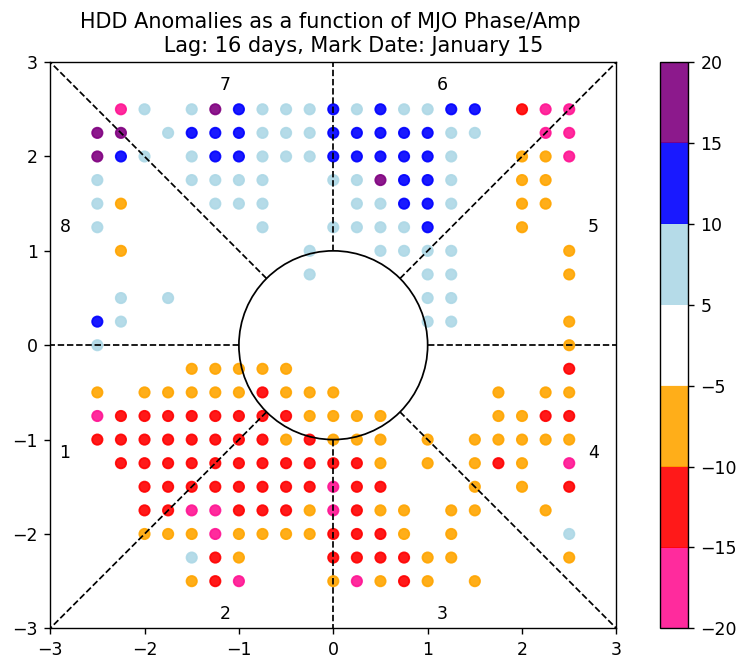

In [10]:
fig = plt.figure(figsize=(9,6),dpi=125)
ax = plt.axes()

if DD_Type == 'hdd_anom':
    clevprecip = np.array([-20,-15,-10,-5,+5,10,15,20])
    colors_MJO= [('deeppink'),('red'), ('orange'), ('white'), ('lightblue'), ('blue'),('purple')]
else:
    clevprecip = np.array([-10,-7,-4,-1,1,4,7,10])
    colors_MJO= [('purple'),('blue'), ('lightblue'), ('white'), ('orange'), ('red'),('deeppink')]

cmap2= mcolors.ListedColormap(colors_MJO, 'MJOPhaseAmp');
newcmp = ListedColormap(colors_MJO)
norm = mcolors.BoundaryNorm(clevprecip, newcmp.N)

#t =  ax.scatter(rmm1_range_adj, rmm2_range_adj, c=DD_Mean_List, cmap='bwr_r',alpha=.9,vmin=-10,vmax=10)
t  =  ax.scatter(rmm1_range_adj, rmm2_range_adj, c=DD_Mean_List, cmap=newcmp, norm=norm, alpha=.9)

cbar=plt.colorbar(t,ticks=clevprecip,pad=0.05, aspect=20)

if DD_Type == 'hdd_anom':
    ax.set(xlim=(-3, 3), ylim=(-3, 3), aspect='equal', title='HDD Anomalies as a function of MJO Phase/Amp \n  \
    Lag: ' + str(abs(shift_num_days)-1) + f' days, Mark Date: {today:%B %d}')
else:
    ax.set(xlim=(-3, 3), ylim=(-3, 3), aspect='equal', title='CDD Anomalies as a function of MJO Phase/Amp \n  \
    Lag: ' + str(abs(shift_num_days)-1) + f' days, Mark Date: {today:%B %d}')   
draw_mjo_phase(ax)

# Scratch